# 期末專案：針對華燈初上之主題探討

**Autor:** Group8 林昱秀、龔紫雲、周映君、蔡旻蓉 <br>
**Date Created:** 2021/01/15<br>
**Last Modified:** 2021/01/17 <br>

本次專案將針對「華燈初上」於PTT上的討論，進行社群上的圖學分析與應用。  
本次專案將先透過LDA為資料進行主題分析，再以不同角度、主題對社群進行篩選，進行網路分析。 

## 專案動機
從去年一路至今，「華燈初上」此戲劇於Netflix上造成一波轟動，除了聚集了台灣許多大牌戲劇演員齊聚一堂外，緊湊而具年代感的劇情鋪陳，更是讓全台灣陷入一陣討論劇情及誰是兇手的瘋狂中。而在網路平台上有許多網友爭相討論劇中角色、劇情、以及推論到底誰會是兇手，關於華燈初上的主題討論，網友各自有其擁護及指認的角色。

而我們也因應此新興主題，以戲劇中會出現的人名、情境等資訊加入自定義的詞典之中，加強後續分析的準確性。另一方面，本次專案使用LDA了解發文主題的分佈，進行主題分類討論分析外；也使用N-gram字詞相關網路圖，以此了解有哪些關鍵字間具有高度關聯性。之後我們以日期、主題進行篩選，抓出社群網路中主要的討論者。最後再探討討論之文章其推、噓程度為何。

## 大綱

- 1. 載入套件
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理，及建立字典
- 3. LDA
    - 3.1 LDA資料準備
    - 3.2 建立LDA
    - 3.3 判斷每筆資料之發文主題
    - 3.4 資料內容探索及每日主題分佈
    - 3.5 N-gram 字詞相關網路圖
- 4. 社群網路圖
    - 4.1 基本網路圖
    - 4.2 資料篩選
    - 4.3 以日期篩選社群
    - 4.4 以主題篩選社群
    - 4.5 使用者是否受到歡迎

## 分析目標
分析主題：2021/11/22 ~ 2022/01/15 期間，PTT上對於「華燈初上」的討論及留言。

> 這次我們針對台劇華燈初上，討論ptt版上相關討論的發文風向，主要針對以下方向分析：  
1.華燈初上的討論重點有哪些? 主要分為哪幾種風向?  
2.風向最偏哪邊?  
3.討論此戲劇的社群網路如何分布?  
4.討論此戲劇的意見領袖有誰?網友的推噓狀態如何?

In [1]:
%pwd

'/Users/caiminrong/Downloads/期末報告G8'

## 1. 載入套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models

In [3]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/caiminrong/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 2.資料前處理

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT 台劇版2021/11/22 ~ 2022/01/15  所有文章
- 資料集： light_articleMetaData.csv; light_articleReviews.csv
- 關鍵字：華燈初上,蘿絲,Rose,羅雨儂,蘇慶儀,愛子,阿季,蘇媽媽,Netflix,網飛,光,ヒカリ
- 資料時間：2021/11/22 ~ 2022/01/15 
- 資料筆數：共 10327 篇文章

In [5]:
#匯入資料
MetaData = pd.read_csv('./light_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./light_articleReviews.csv', encoding='UTF-8')

In [6]:
MetaData.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[討論]無神之地不下雨到第七集的猜測,2021/11/22,00:09:16,https://www.ptt.cc/bbs/TaiwanDrama/M.163753975...,cofee,TaiwanDrama,32,20,0,雖然已看到最新\n\n但應該沒有第七集的雷\n\n純粹猜測 現在Fali的想法\n\n在月台...
1,[無神]無神之地不下雨1-7集隨便聊,2021/11/23,05:31:39,https://www.ptt.cc/bbs/TaiwanDrama/M.163764550...,bomito,TaiwanDrama,42,16,0,閒聊前的閒聊～\n\n這一部其實剛開播時看了半集直接棄劇\n覺得雖然是劇情需要，但男主角雨之...
2,[新聞]章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案,2021/11/23,17:09:57,https://www.ptt.cc/bbs/TaiwanDrama/M.163768740...,ttnakafzcm,TaiwanDrama,0,0,0,章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案\n\nNetflix攜手百聿數碼推出旗艦懸疑影集...
3,[情報]《我願意》2021年金馬影展首映全紀實、影評推薦,2021/11/24,07:58:18,https://www.ptt.cc/bbs/TaiwanDrama/M.163774070...,AmyLien,TaiwanDrama,1,1,0,《The Amazing Grace of Σ》《我願意》2021年金馬影展首映全紀實\nh...
4,[新聞]于子育自嘲「吻仔魚腦」錯把曾之喬叫成「天心」,2021/11/24,16:27:54,https://www.ptt.cc/bbs/TaiwanDrama/M.163777127...,ttnakafzcm,TaiwanDrama,4,2,0,于子育自嘲「吻仔魚腦」 錯把曾之喬叫成「天心」\n\n愛奇藝、華視、八大電視共同推出的《無神...


In [7]:
# 再篩一次文章
keywords = ['華燈初上','蘿絲','Rose','羅雨儂','蘇慶儀','愛子','阿季','蘇媽媽','Netflix','網飛','光','ヒカリ']
toMatch = '|'.join(keywords)


In [8]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(168, 10)


In [9]:
MetaData['sum']=MetaData['push']+MetaData['boo']

In [10]:
MetaData.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum
0,[討論]無神之地不下雨到第七集的猜測,2021/11/22,00:09:16,https://www.ptt.cc/bbs/TaiwanDrama/M.163753975...,cofee,TaiwanDrama,32,20,0,雖然已看到最新\n\n但應該沒有第七集的雷\n\n純粹猜測 現在Fali的想法\n\n在月台...,20
1,[無神]無神之地不下雨1-7集隨便聊,2021/11/23,05:31:39,https://www.ptt.cc/bbs/TaiwanDrama/M.163764550...,bomito,TaiwanDrama,42,16,0,閒聊前的閒聊～\n\n這一部其實剛開播時看了半集直接棄劇\n覺得雖然是劇情需要，但男主角雨之...,16
2,[新聞]章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案,2021/11/23,17:09:57,https://www.ptt.cc/bbs/TaiwanDrama/M.163768740...,ttnakafzcm,TaiwanDrama,0,0,0,章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案\n\nNetflix攜手百聿數碼推出旗艦懸疑影集...,0
3,[情報]《我願意》2021年金馬影展首映全紀實、影評推薦,2021/11/24,07:58:18,https://www.ptt.cc/bbs/TaiwanDrama/M.163774070...,AmyLien,TaiwanDrama,1,1,0,《The Amazing Grace of Σ》《我願意》2021年金馬影展首映全紀實\nh...,1
4,[新聞]于子育自嘲「吻仔魚腦」錯把曾之喬叫成「天心」,2021/11/24,16:27:54,https://www.ptt.cc/bbs/TaiwanDrama/M.163777127...,ttnakafzcm,TaiwanDrama,4,2,0,于子育自嘲「吻仔魚腦」 錯把曾之喬叫成「天心」\n\n愛奇藝、華視、八大電視共同推出的《無神...,2


In [11]:
MetaData['sum'] = MetaData['sum'].astype(int)

In [12]:
MetaData = MetaData.drop(MetaData[MetaData['sum'] < 30].index)

In [13]:
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum
7,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...,274
8,[討論]華燈初上第一季(雷),2021/11/27,05:50:32,https://www.ptt.cc/bbs/TaiwanDrama/M.163799223...,zorgYen,TaiwanDrama,119,70,0,昨晚一口氣就追完八集，覺得編劇蠻厲害的，\n雖然時間幕跳來跳去，會讓人邊想排序一下。\n而且...,70
9,[討論]華燈初上（有雷,2021/11/27,08:31:36,https://www.ptt.cc/bbs/TaiwanDrama/M.163800189...,vivian0515,TaiwanDrama,316,133,0,先吐槽一下：\n我昨天一口氣的看完了八集\n只能說有點失望 但是有點不知道失望感從何而來\n...,133
11,[閒聊]華燈初上最喜歡哪個角色？,2021/11/28,14:53:54,https://www.ptt.cc/bbs/TaiwanDrama/M.163811123...,lovely0930,TaiwanDrama,216,134,0,有劇情雷\n請觀賞過後再觀看\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,134
12,[心得]華燈初上-林森北路上的雙姝怨,2021/11/28,23:16:41,https://www.ptt.cc/bbs/TaiwanDrama/M.163814140...,MBAR,TaiwanDrama,335,110,5,老實說一開始看到這部劇的卡司還有製作人的時候\n\n我是很擔心的。\n\n大家都知道林心如過...,115
...,...,...,...,...,...,...,...,...,...,...,...
146,[請益]求大家推薦類似華燈初上的影集,2022/01/08,14:26:42,https://www.ptt.cc/bbs/TaiwanDrama/M.164165200...,laiteng0105,TaiwanDrama,56,39,0,最近看了華燈覺得超讚的\n不管服裝場景設計 配樂全部都非常剛好\n想問大家有推薦類似這樣的台...,39
153,[華燈]華燈初上第二季最後一幕後照鏡雷,2022/01/09,15:00:54,https://www.ptt.cc/bbs/TaiwanDrama/M.164174045...,InfocusM510,TaiwanDrama,111,81,0,有雷\n\n有雷\n\n有雷\n\n\n\n\n\n\n\n\n\n\n華燈初上第二季最後一...,81
155,[討論]華燈初上不負責任猜測,2022/01/10,09:02:41,https://www.ptt.cc/bbs/TaiwanDrama/M.164180536...,pwl,TaiwanDrama,100,30,0,人在日本，剛看完兩季華燈，好想分享一下心得和一點推理\n\n首先要讚美一下這部戲的質感，\n...,30
157,[討論]演員真的都會抽菸嗎?,2022/01/11,03:50:56,https://www.ptt.cc/bbs/TaiwanDrama/M.164187305...,QchchQ,TaiwanDrama,176,68,3,看完華燈初上\n\n可能時代背景跟職業關西\n\n幾乎每個人人手一支菸\n\n看起來也不是點...,71


In [14]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[討論]無神之地不下雨到第七集的猜測,2021/11/22,00:09:16,https://www.ptt.cc/bbs/TaiwanDrama/M.163753975...,cofee,TaiwanDrama,smallshu0418,推,2021-11-22 08:23:00,:雖然進度慢但還是想一直看～有看分享要到11集才會劇
1,[討論]無神之地不下雨到第七集的猜測,2021/11/22,00:09:16,https://www.ptt.cc/bbs/TaiwanDrama/M.163753975...,cofee,TaiwanDrama,smallshu0418,→,2021-11-22 08:23:00,:情明朗XD
2,[討論]無神之地不下雨到第七集的猜測,2021/11/22,00:09:16,https://www.ptt.cc/bbs/TaiwanDrama/M.163753975...,cofee,TaiwanDrama,sandymo,推,2021-11-22 09:38:00,:進度很慢+1總共不是才13集嗎


In [15]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [16]:
print(Reviews.shape)
Reviews.head(3)

(10327, 14)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表,sodabubble,→,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表
1,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...,:時間是每集首播前的兩小時內。例如16:00開播，[LIVE],sodabubble,→,:時間是每集首播前的兩小時內。例如16:00開播，[LIVE]
2,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...,:文的發表時間即為當天的14:00~16:00。敬請參考~,sodabubble,→,:文的發表時間即為當天的14:00~16:00。敬請參考~


### 2.2 資料清理  
- 去除特殊字元與標點符號

In [17]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

### 2.3 文章斷詞與整理

### Create dictonary

In [18]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

#新增戲劇相關自定義字典
jieba.load_userdict('./dict/user_dict.txt')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/caiminrong/Downloads/期末報告G8/dict/dict.txt ...
Dumping model to file cache /var/folders/qs/v34r1tz92mddbmqp6bhm13b00000gn/T/jieba.uacc484140fede949fa470f9402b2345a.cache
Loading model cost 0.639 seconds.
Prefix dict has been built successfully.


In [19]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [20]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [21]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word
7,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,"華燈初上 ,,,,,,正式預告,,羅雨儂和蘇慶儀的故事在她們還是女孩的時候 就已經開始了。...",274,"[華燈初上, 正式, 預告, 羅雨儂, 蘇慶儀, 故事, 女孩, 生長, 背景, 個性, 天..."
8,[討論]華燈初上第一季(雷),2021/11/27,05:50:32,https://www.ptt.cc/bbs/TaiwanDrama/M.163799223...,zorgYen,TaiwanDrama,119,70,0,"昨晚一口氣就追完八集，覺得編劇蠻厲害的，,雖然時間幕跳來跳去，會讓人邊想排序一下。,而且這第...",70,"[昨晚, 一口氣, 追完, 八集, 編劇, 厲害, 時間, 跳來跳去, 人邊, 排序, 第一..."
9,[討論]華燈初上（有雷,2021/11/27,08:31:36,https://www.ptt.cc/bbs/TaiwanDrama/M.163800189...,vivian0515,TaiwanDrama,316,133,0,"先吐槽一下：,我昨天一口氣的看完了八集,只能說有點失望 但是有點不知道失望感從何而來,其實我...",133,"[先吐槽, 昨天, 一口氣, 看完, 八集, 只能, 失望, 失望感, 從何, 跳來跳去, ..."


## 3. LDA

### 3.1 LDA資料準備
- 將斷詞結果轉成list型式，使用id2word 將斷詞結果生成字典

In [22]:
token_data = data['word'].tolist()

In [23]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(4138 unique tokens: ['一間', '上線', '主演', '人生', '修杰楷']...)


- 將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。  
- 每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。

In [24]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:3])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1)]


### 3.2 建立LDA

In [25]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=2, # 生成幾個主題數
    random_state=2022, # 亂數
    iterations = 2000, # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5, # 模型訓練次數
)

In [26]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./test2.html')

### 3.3 判斷每筆發文的主題
**查看 LDA 各主題代表字**  
- 查看每個主題的單詞分佈

In [27]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -4.74190605191766


In [28]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.057533686063667


In [29]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 2022,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.057534,3157.492915
1,4,-8.122535,3369.550744
2,6,-8.138477,3423.698024
3,8,-8.166846,3522.215656


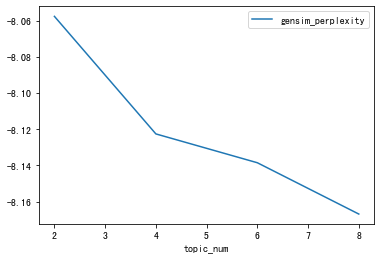

In [30]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-8.057534,3157.492915
1,4,-8.122535,3369.550744
2,6,-8.138477,3423.698024
3,8,-8.166846,3522.215656


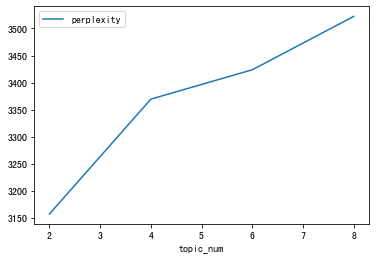

In [31]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

由perplexity可得知，2個topic是最合適的。

In [32]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.008*"角色" + 0.007*"林心如" + 0.006*"酒店" + 0.005*"蘇慶儀" + 0.004*"劇情" + 0.004*"演員" + 0.004*"羅雨儂" + 0.004*"楊謹華" + 0.004*"媽媽" + 0.004*"華燈初上" + 0.004*"阿季" + 0.003*"演出" + 0.003*"小姐" + 0.003*"客人" + 0.003*"演技" + 0.003*"日式" + 0.003*"客串" + 0.003*"年代" + 0.003*"背景" + 0.003*"第二季" + 0.002*"條通" + 0.002*"華燈" + 0.002*"吳慷仁" + 0.002*"郭雪芙" + 0.002*"鳳小岳"')

(1, '0.008*"兇手" + 0.007*"阿達" + 0.006*"子維" + 0.006*"角色" + 0.005*"毒品" + 0.005*"第二季" + 0.005*"江瀚" + 0.005*"媽媽" + 0.005*"劇情" + 0.004*"阿季" + 0.004*"自殺" + 0.004*"喜歡" + 0.004*"淑華" + 0.003*"何予恩" + 0.003*"中村先生" + 0.003*"蘇慶儀" + 0.003*"日本" + 0.003*"第一季" + 0.003*"華燈" + 0.003*"錄音機" + 0.003*"羅絲" + 0.002*"線索" + 0.002*"成哥" + 0.002*"編劇" + 0.002*"江翰"')



**可以歸納出**
- topic 0 = “討論華燈初上的角色陣容”
- topic 1 = “討論劇情內各角色間的愛恨情仇與劇情兇手是誰”  
 
<b><mark><font color=red>*以下我們挑出 第0個主題 與 第1個主題 來做比較。 </font></mark></b> 

**以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題**

In [33]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.9919059, 0.008094079], [0.87163496, 0.1283651], [0.9876143, 0.012385719]]


In [34]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [35]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
7,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,0
8,[討論]華燈初上第一季(雷),0
9,[討論]華燈初上（有雷,0
11,[閒聊]華燈初上最喜歡哪個角色？,1
12,[心得]華燈初上-林森北路上的雙姝怨,0


### 3.4 資料內容探索

**3.4.1畫出每日主題分布**

In [36]:
# 轉換artDate為 Python 日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")

In [37]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,artDate,topic,count
0,2021-11-26,0,1
1,2021-11-27,0,2
2,2021-11-28,0,1
3,2021-11-28,1,1
4,2021-11-29,0,1
5,2021-11-29,1,1
6,2021-11-30,0,1
7,2021-12-01,0,1
8,2021-12-01,1,1
9,2021-12-02,0,1


In [38]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1']
date_df = date_df.set_index('artDate')
date_df.head(5)

,topic0,topic1
artDate,,
2021-11-26,1.0,0.0
2021-11-27,2.0,0.0
2021-11-28,1.0,1.0
2021-11-29,1.0,1.0
2021-11-30,1.0,0.0


各主題的討論程度每日都會浮動，可看出網友們對於華燈初上的各討論topic都很熱烈。

### 3.5 N-gram 字詞相關網路圖

為了更進一步的探討，我們將文章根據主題模型的結果進行分類，並且針對每個不同的主題文章進行 N-Gram 分析且繪製出字辭相關網路圖，目的是為了能更加瞭解主題模型所歸納出的2個主題分別有哪些意義。

In [39]:
data_topic1 = data[data['topic']==0] # 
data_topic2 = data[data['topic']==1] # 


In [40]:
bigramfdist1 = FreqDist()
bigramfdist2 = FreqDist()

def bigram_getToken_dict(row,dist,n=2):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    dist.update(ngrams(seg_list, n))
    seg_list2 = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [41]:
data_topic1["word"] = data_topic1.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist1))
data_topic2["word"] = data_topic2.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist2))

<ipython-input-41-77b9211923e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_topic1["word"] = data_topic1.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist1))
<ipython-input-41-77b9211923e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_topic2["word"] = data_topic2.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist2))


In [42]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d1 = {k:v for k,v in bigramfdist1.most_common(30)}
d2 = {k:v for k,v in bigramfdist2.most_common(30)}

In [43]:
G1 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d1][0].items():
    G1.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights1 = [w[2]['weight']*0.03 for w in  G1.edges(data=True)]

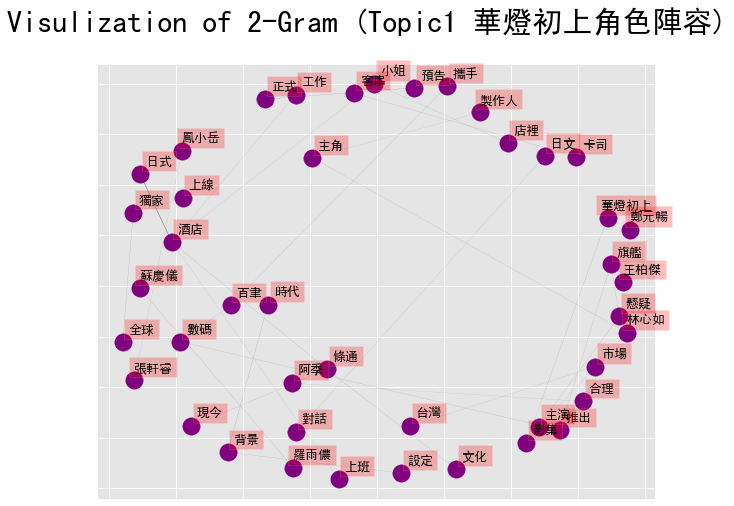

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G1, k=2)

# networks
nx.draw_networkx(G1, pos,
                 font_size=16,
                 width=weights1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic1 華燈初上角色陣容)', fontsize=30)    
plt.show()

In [45]:
G2 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d2][0].items():
    G2.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights2 = [w[2]['weight']*0.03 for w in  G2.edges(data=True)]

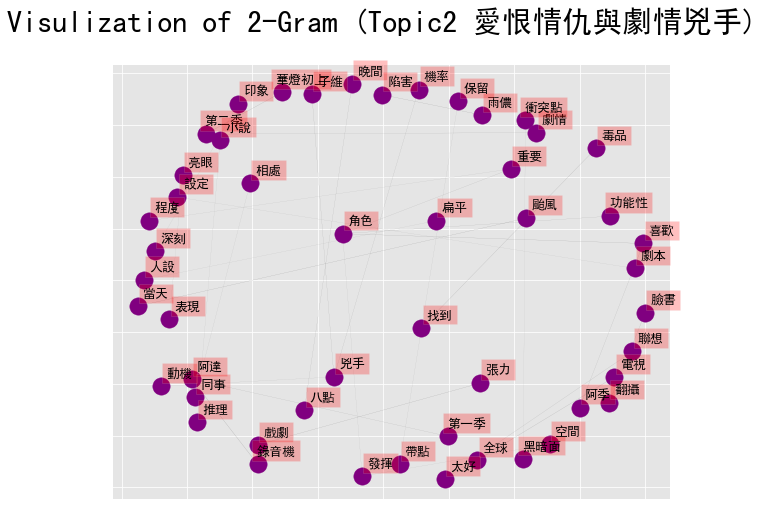

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G2, k=2)

# networks
nx.draw_networkx(G2, pos,
                 font_size=16,
                 width=weights2,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic2 愛恨情仇與劇情兇手)', fontsize=30)    
plt.show()

雖然我們已經透過主題模型的結果，將文章切分成兩個主題，但透過N gram 字詞相關網路圖的結果會發現，各自不同主題的文章其實都有高度重疊的部分，因為我們再製作 字詞相關網路圖 時採用的統計量是字辭頻率，因此我們可以從以上的結果發現真正決定主題模型的主題劃分應當是在較少數的字詞上，但不同的主題文章大部分會出現的字詞幾乎都是一致的。而這個發現帶給我們的收穫是，如果要真正地繪製出不同主題下文章的字詞相關網路圖，我們應當刪去那些共同出現在不同主題文章中的字詞，才更能夠看出不同主題文章下的內容差異。

## 4. 社群網路圖
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構。

### 4.1 基本網路圖

In [47]:
data.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word,topic
7,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021-11-26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,"華燈初上 ,,,,,,正式預告,,羅雨儂和蘇慶儀的故事在她們還是女孩的時候 就已經開始了。...",274,"[華燈初上, 正式, 預告, 羅雨儂, 蘇慶儀, 故事, 女孩, 生長, 背景, 個性, 天...",0


In [48]:
Reviews.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表,sodabubble,→,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表


In [49]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [50]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021-11-26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,"華燈初上 ,,,,,,正式預告,,羅雨儂和蘇慶儀的故事在她們還是女孩的時候 就已經開始了。...",274,"[華燈初上, 正式, 預告, 羅雨儂, 蘇慶儀, 故事, 女孩, 生長, 背景, 個性, 天...",0,sodabubble,→,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表,:(不是責怪原po，是建議與說明~)臺劇板的[LIVE]發表
1,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021-11-26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,432,271,3,"華燈初上 ,,,,,,正式預告,,羅雨儂和蘇慶儀的故事在她們還是女孩的時候 就已經開始了。...",274,"[華燈初上, 正式, 預告, 羅雨儂, 蘇慶儀, 故事, 女孩, 生長, 背景, 個性, 天...",0,sodabubble,→,:時間是每集首播前的兩小時內。例如16:00開播，[LIVE],:時間是每集首播前的兩小時內。例如16:00開播，[LIVE]


In [51]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,sodabubble,YRanger,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...
1,sodabubble,YRanger,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...
2,sodabubble,YRanger,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...
3,YRanger,YRanger,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...
4,n731662000,YRanger,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...


In [52]:
len(link)

10327

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，這裡先嘗試使用前100筆資料(總共有10327筆資料)

In [53]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])
    

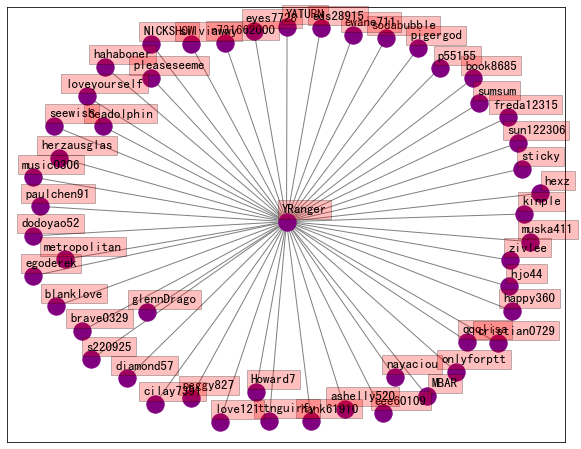

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜(10327筆資料)，所以我們下面需要做進一步篩選。

### 4.2 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

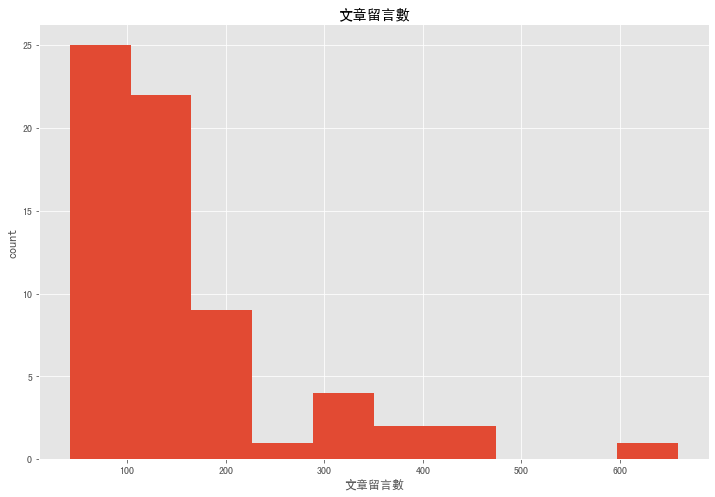

In [55]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

依據發文數或回覆數篩選post和review

In [56]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
37,markwu123,3
30,jung1211,2
16,Tiara5566,2
32,kiradu,2
53,zihying,2
34,lovely0930,2
44,ttnakafzcm,2
29,jj96857400,2
31,justicem,1
33,laiteng0105,1


In [57]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 57
回覆者數量總共: 2111


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [107]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [108]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [109]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replyer")

In [110]:
allPoster.head(5)

,user,type
0,smallwind,replyer
1,rolly11,replyer
2,Jkia,replyer
3,tatattaa,replyer
4,yaliieah,replyer


### 4.3 以日期篩選社群

 我們從下方「每月文章篇數」來看，可以發現2022/01/02的文章篇數明顯多於其他天數，故我們從此天作為篩選依據。

In [62]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': data.groupby('artDate').size().index,
    'count': data.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

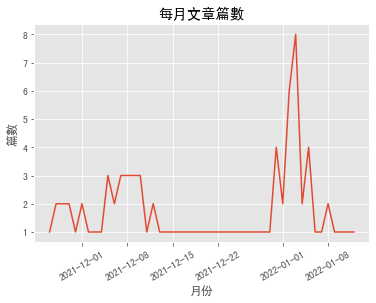

In [63]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

In [101]:
# 篩選日期為2021-01-02 且 留言數>50的
posts_Reviews_0102 = (posts_Reviews.query('artDate == "2022-01-02"')
                      .query('commentNum>50')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [102]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_0102 = posts_Reviews_0102.query('size>5')
posts_Reviews_0102.head(3)

,cmtPoster,artUrl,size
24,Ciline,https://www.ptt.cc/bbs/TaiwanDrama/M.164112257...,7
31,Dirito,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,7
43,GO77,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,6


In [103]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0102 = pd.merge(posts_Reviews_0102,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0102.reset_index(inplace=True, drop=True) #重設index
link_0102.head(3)

,cmtPoster,artUrl,size,artPoster
0,Ciline,https://www.ptt.cc/bbs/TaiwanDrama/M.164112257...,7,GarfieldCxT
1,Dirito,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,7,zihying
2,GO77,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,6,zihying


In [104]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_0102)):
    G.add_edge(link_0102["cmtPoster"][i], link_0102["artPoster"][i])

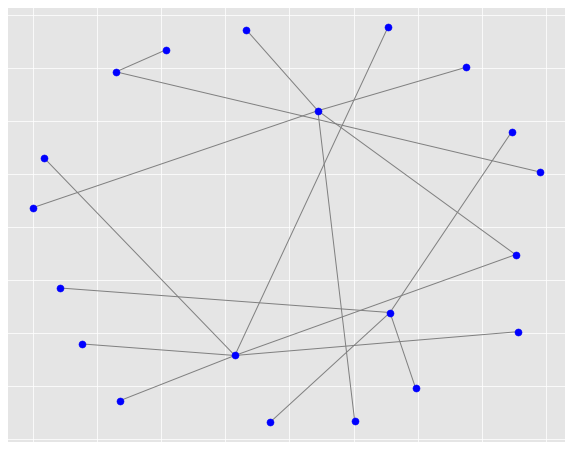

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

**加上nodes的顯示資訊**  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [111]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

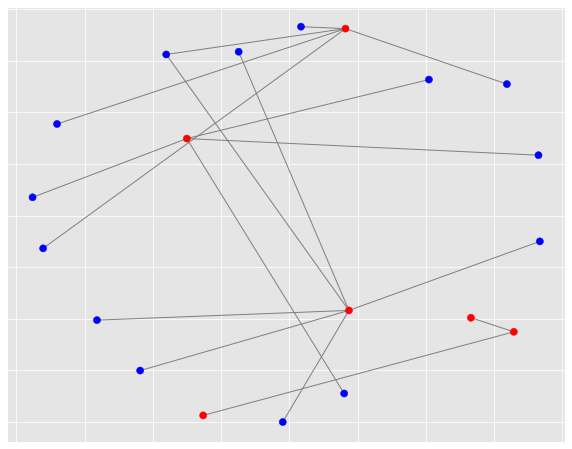

In [112]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。  

In [71]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) < 1]
for x in to_be_removed:
    G.remove_node(x)

In [113]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [114]:
# 找出degree>1的點
degrees = [node for (node, val) in G.degree() if val>1]
degrees

['GarfieldCxT', 'zihying', 'vores', 'ss61512tw', 'smydguo']

In [115]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

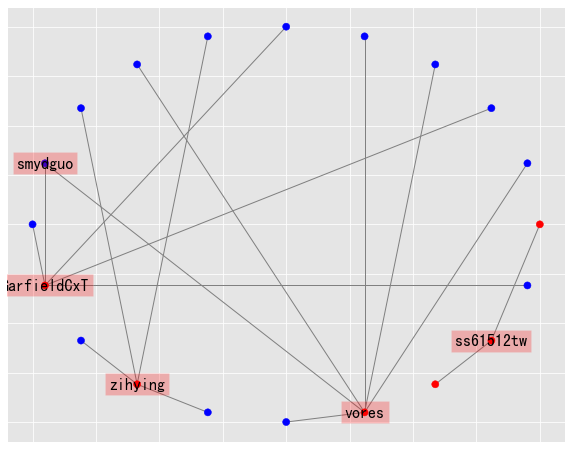

In [116]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
#pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

In [76]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'Ciline': 0.05263157894736842,
 'GarfieldCxT': 0.2631578947368421,
 'Dirito': 0.05263157894736842,
 'zihying': 0.21052631578947367,
 'GO77': 0.05263157894736842,
 'KID543': 0.05263157894736842,
 'vores': 0.3157894736842105,
 'MBAR': 0.05263157894736842,
 'ss61512tw': 0.10526315789473684,
 'NICKSHOW': 0.05263157894736842,
 'REDBLUEr': 0.05263157894736842,
 'bettybuy': 0.05263157894736842,
 'bkool': 0.05263157894736842,
 'dowcher': 0.05263157894736842,
 'htk': 0.05263157894736842,
 'mag1021': 0.05263157894736842,
 'nancyh': 0.05263157894736842,
 'overhead': 0.05263157894736842,
 'polysmallfan': 0.05263157894736842,
 'smydguo': 0.10526315789473684}

In [77]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [78]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.5)

In [79]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [80]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['vores', 'GarfieldCxT', 'zihying', 'ss61512tw', 'smydguo']
eigenvector centrality: ['vores', 'smydguo', 'GarfieldCxT', 'KID543', 'bettybuy']
pagerank centrality: ['vores', 'GarfieldCxT', 'zihying', 'ss61512tw', 'smydguo']
betweenness centrality: ['vores', 'GarfieldCxT', 'smydguo', 'zihying', 'ss61512tw']


從這個部分我們可以看到基本的使用者關係，從各個角度的中心性排名來看，可以得知最為頻繁出現的有：vores, GarfieldCxT, zihying, smydguo, ss61512。

### 4.4 以主題篩選社群

挑選出2022-01-02當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於200則， 文章主題歸類為0(報導相關)與2(調侃)者， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [105]:
# 加上topic
topic_0102 = pd.merge(link_0102,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [106]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0102_topic = pd.merge(topic_0102,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0102_topic.reset_index(inplace=True, drop=True) #重設index
link_0102_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,Ciline,https://www.ptt.cc/bbs/TaiwanDrama/M.164112257...,0,GarfieldCxT
1,Dirito,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,1,zihying
2,GO77,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,1,zihying


In [83]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_0102_topic)):
    G.add_edge(link_0102_topic["cmtPoster"][i], link_0102_topic["artPoster"][i])
    if link_0102_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:人物角色相關
    else: 
        color_map_edge.append('grey') # 主題一:愛恨情仇與兇手相關   

In [84]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) < 1]
for x in to_be_removed:
    G.remove_node(x)

In [117]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [118]:
# 找出degree>2的點
degrees = [node for (node, val) in G.degree() if val>2]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

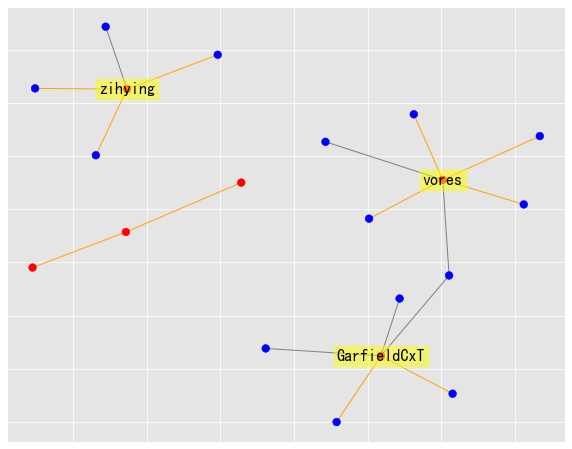

In [119]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.5)

# networks
nx.draw_networkx(G, pos,
                 node_size=60,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='yellow', alpha=0.5),
                        horizontalalignment='center')
    
plt.show()

人物角色討論相關為橘色，愛恨情仇及兇手相關為灰色。而藍色點代表僅有回覆他人文章者。可以看出在2022/01/02這天，主要發文者zihying, vores,GarfieldCxT皆在兩種議題有平均的討論，而GarfieldCxT與vores中間有所連結。

### 4.5 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [88]:
# 加上status
status_1218 = pd.merge(link_1218,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1218 = status_1218[status_1218["cmtStatus"]!="→"]

In [89]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1218_status = pd.merge(status_1218,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1218_status.reset_index(inplace=True, drop=True) #重設index
link_1218_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,Ciline,https://www.ptt.cc/bbs/TaiwanDrama/M.164112257...,0,推,GarfieldCxT
1,Dirito,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,1,推,zihying
2,GO77,https://www.ptt.cc/bbs/TaiwanDrama/M.164112395...,1,推,zihying


In [90]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1218_status)):
    G.add_edge(link_1218_status["cmtPoster"][i], link_1218_status["artPoster"][i])
    if link_1218_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [91]:
# 刪除degree<1的點
#to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
#for x in to_be_removed:
 #   G.remove_node(x)

In [120]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [121]:
# 找出degree>3的點
degrees = [node for (node, val) in G.degree() if val>2]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

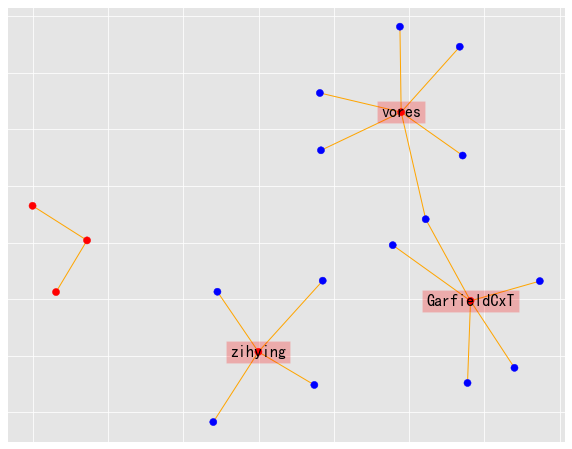

In [122]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.5)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

可以發現本次的討論中幾乎都是以推文為主。

In [95]:
MetaData = pd.read_csv('./light_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./light_articleReviews.csv', encoding='UTF-8')

In [96]:
filter1 = MetaData["artPoster"] == "vores"
MetaData[filter1]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
93,[閒聊]#無雷華燈初上誰讓你最出戲,2022/01/02,01:41:44,https://www.ptt.cc/bbs/TaiwanDrama/M.164108770...,vores,TaiwanDrama,333,190,4,華燈很多人的演技真的是讓人為之驚艷\n劉品言 李李仁 吳慷仁的演技真的很吸睛\n不過大家有沒...


In [97]:
filter2 = Reviews["cmtPoster"] == "vores"
Reviews[filter2]['cmtContent']

Series([], Name: cmtContent, dtype: object)

In [98]:
filter3 = MetaData["artPoster"] == "GarfieldCxT"
MetaData[filter3]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
97,[閒聊]為什麼華燈初上每個場景都在抽菸？,2022/01/02,11:22:53,https://www.ptt.cc/bbs/TaiwanDrama/M.164112257...,GarfieldCxT,TaiwanDrama,203,92,7,有名字的角色裡\n沒抽菸的好像沒幾個\n\n是我的同溫層抽菸比例太低嗎？\n身邊有抽菸的朋友...


此部分我們將主要的社群中心發文者發佈的文章拉出來看其文章內容細節為何。